# Analysis of Ronchi Grating
This code is for prototyping the investigation of the resolution of the OPT system using a grating.

1. Imports image stack of grating, perform averaging operation
2. Investigates whether there is rotational misalignment of the grating
3. Finds in-focus grating image
4. Takes 2D FFT
5. Analyses the frequency component
   1. Uses central spectrum of FFT to find harmonic peaks
6. Defines ideal Ronchi grating function
7. 



In [2]:
import skimage
from skimage import io
import matplotlib.pyplot as plt

from scipy.fft import fft, fft2,fftshift, fftfreq
import numpy as np
import scipy as sp
import pandas as pd

Loads image of Ronchi grating in.

In [8]:
# PATH_TO_IMAGE =  '../../OPT Shared files/2022-10-31 dof contd/aperture/2022-10-31-f6 depth sweep wide range stack/MMStack_Pos0.ome.tif'
PATH_TO_IMAGE =  '../../OPT Shared files/2023-01-17 grating redone/2023-01-17 grating in water f-a/MMStack_Pos0.ome.tif'
im_stack = io.imread(PATH_TO_IMAGE)

In [94]:
im_stack.shape

(125, 1392, 1040)

In [172]:
def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(dim_0//num_repeats, num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=1)
    return output
    
num_repeats = 5
im_stack = get_averaged_stack(im_stack, num_repeats)


Investigation of Variance

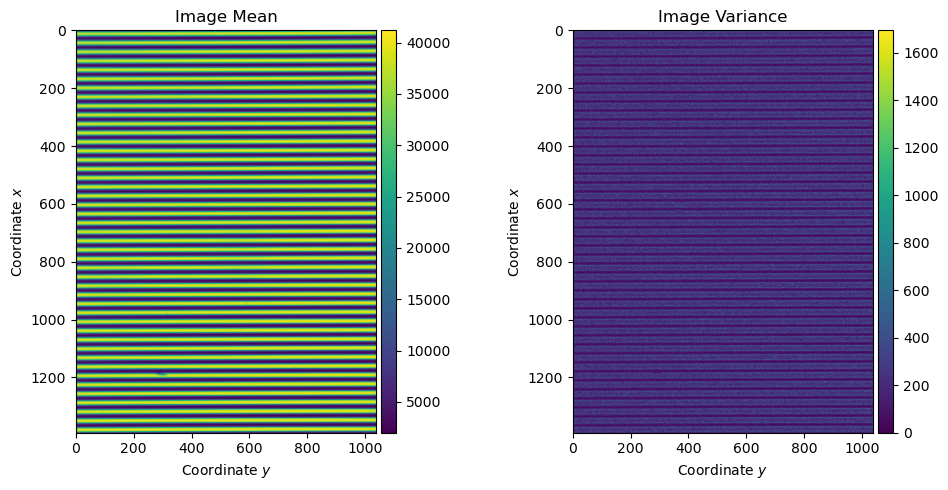

In [170]:
# Compute pixel-wise variance
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Manually reshape array
dim_0, im_length, im_width = im_stack.shape
reshaped = im_stack.reshape(dim_0//num_repeats, num_repeats, im_length, im_width)

im_mean = np.mean(reshaped[14], axis=0)
im_std = np.std(reshaped[14], axis=0)

# Plot images
fig, ax = plt.subplots(1,2, figsize=(10,5))
im_0 = ax[0].imshow(im_mean)
im_1 = ax[1].imshow(im_std)
# fig.colorbar(im_0)

# Set colourbars for the two images
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_0, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_1, cax=cax, orientation='vertical')

# Label the axes
ax[0].set_title('Image Mean')
ax[0].set_ylabel('Coordinate $x$')
ax[0].set_xlabel('Coordinate $y$')
ax[1].set_title('Image Variance')
ax[1].set_ylabel('Coordinate $x$')
ax[1].set_xlabel('Coordinate $y$')
plt.tight_layout()

Find in-focus frame. The frame in focus is likely the one with the maximum and minimum brightness.

In [173]:
np.unravel_index(np.argmax(im_stack), im_stack.shape), np.unravel_index(np.argmin(im_stack), im_stack.shape)

((12, 847, 1036), (11, 60, 238))

/Users/kenton/opt/anaconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Text(0.5, 0, 'Coordinate $y$')

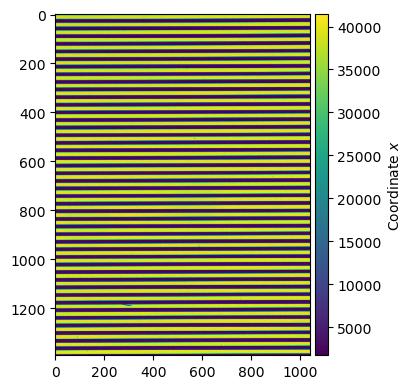

In [174]:
im = im_stack[12]
plt.figure(figsize=(4,4))
io.imshow(im)
plt.ylabel('Coordinate $x$')
plt.xlabel('Coordinate $y$')

### Rotational Misalignment Investigation

Text(0.5, 0, 'Pixel coordinate')

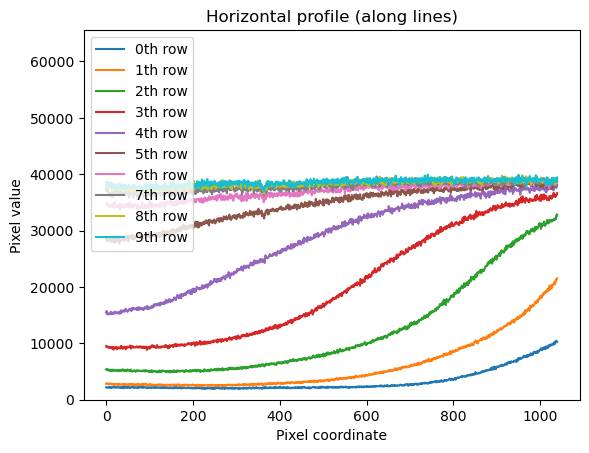

In [175]:
for i in range(0, 10, 1):
    plt.plot(im[i], label=f'{i}th row')

# plt.plot(im[1])
plt.ylim(0,65565)
plt.title('Horizontal profile (along lines)')
plt.ylabel('Pixel value')
plt.legend()
plt.xlabel('Pixel coordinate')

An example line profile, no cropping used.

(0.0, 50.0)

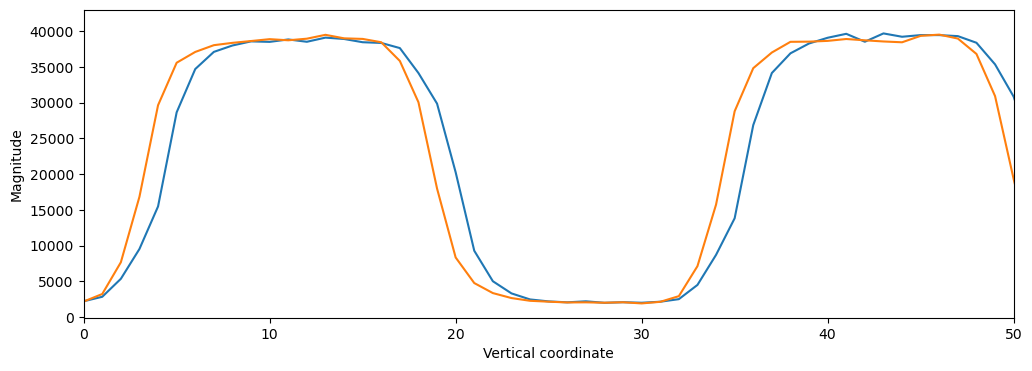

In [176]:
plt.figure(figsize=(12,4))
plt.ylabel('Magnitude')
plt.xlabel('Vertical coordinate')
plt.plot(im[:,0])
plt.plot(im[:,500])
plt.xlim(0,50)

**Unit conversions**

Line pair / mm refers to a frequency unit, which is equivalent to cycles per mm.

We know that 1 pixel has size $e = 6.45 \ \mu m$. Thus 1 pixel represents $l = e/m$ in object space where $m$ is the lens magnification.

The highest frequency that can be sampled is $k = \frac{1}{2l} = \frac{m}{2e}$.

In [177]:
e = 6.45/ 1000 # pixel size (mm)
# m = 0.5
m = 1.0
length_per_pixel = e/m

Text(0.5, 0, 'Horizontal spatial frequency (lp mm$^{-1}$)')

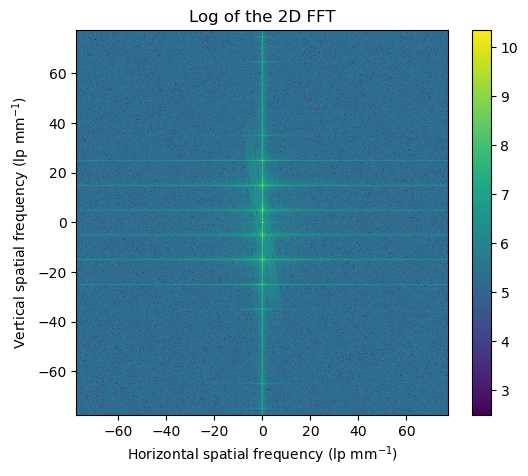

In [178]:
# Take FFT
ft = fftshift(fft2(im[200:1200]))

x_size = ft.shape[0]
y_size = ft.shape[1]

# multiply by 2 to get units in line pairs per mm
x_freqs = fftshift(fftfreq(x_size, d = length_per_pixel)) 
y_freqs = fftshift(fftfreq(y_size, d = length_per_pixel) )


ft_log = np.log10(np.abs(ft))
X,Y = np.meshgrid(x_freqs, y_freqs)
plt.figure(figsize=(6,5))
plt.title('Log of the 2D FFT')
plt.pcolormesh(Y, X, ft_log.T, shading='auto')
plt.colorbar()
plt.ylabel('Vertical spatial frequency (lp mm$^{-1}$)')
plt.xlabel('Horizontal spatial frequency (lp mm$^{-1}$)')

In [78]:
# plt.title('Plot of the FFT (Horizontal slice)')
# plt.plot(x_freqs, (np.abs(ft)[:,0])/np.max(np.abs(ft)), ls='-')
# plt.xlabel('Frequencies (line pairs per mm)')

Extract peaks from the Fourier Transform

In [227]:
peaks_threshold = 0.001
fundamental_threshhold = 0.2 
rtol = 0.02

In [263]:
# Absolute value of the Fourier transform, normalised by its maximum
ft_slice = (np.abs(ft)[:,y_size//2])/np.max(np.abs(ft))
peaks, _ = sp.signal.find_peaks(ft_slice, height=peaks_threshold)

# Extract fundamental frequency 
fundamental_peak, _ = sp.signal.find_peaks(ft_slice, height=fundamental_threshhold)
fundamental_peak = fundamental_peak[-1]
base_frequency = x_freqs[fundamental_peak] 

selected_freqs = x_freqs[peaks]/base_frequency

# Filter out unwanted frequencies
# mask = np.logical_or((np.abs(selected_freqs) > 1) & (np.abs(selected_freqs) < 3 ), (np.abs(selected_freqs) > 0) & (np.abs(selected_freqs) < 1 ))
# peaks = peaks[np.logical_not(mask)]
# print(selected_freqs[np.logical_not(mask)])

# Define function to find peaks near harmonic frequencies
# Determine maximum harmonic using Nyquist frequency divided by base freq
harmonics = np.append(0, np.arange(1, x_freqs[-1]/base_frequency, 2, dtype=int))

def find_matches(input, match, rtol,):
    # Returns binary array with length of (input) where input is close to any
    # element of match with tolerance rtol

    output = np.zeros(len(input), dtype=bool)
    for i, input_value in enumerate(np.abs(input)):
        out = False
        for num in match:
            # When close to limits rtol, set binary array value to be True
            out = out or np.isclose(input_value, num, rtol=rtol)
        output[i] = bool(out)
    return output

peaks = peaks[find_matches(selected_freqs, harmonics, rtol)]

Text(0.5, 1.0, 'Plot of the FFT (Vertical slice)')

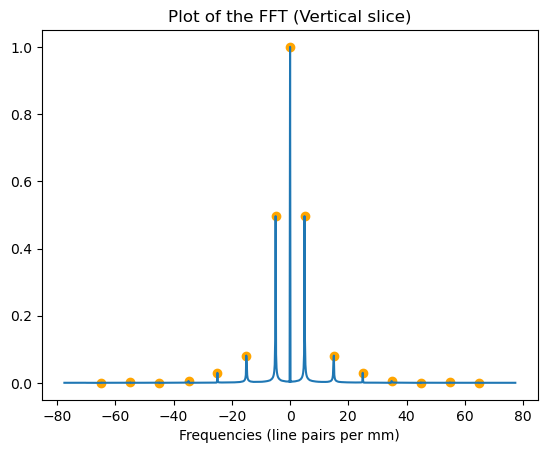

In [213]:
def plot_slice_with_peaks(x_freqs, ft_slice, peaks):
    plt.plot(x_freqs, ft_slice, ls='-')
    plt.scatter(x_freqs[peaks], ft_slice[peaks], c='orange')
    plt.xlabel('Frequencies (line pairs per mm)')
    return
    
plot_slice_with_peaks(x_freqs, ft_slice, peaks)
plt.title('Plot of the FFT (Vertical slice)')
# plt.xlim(34,36)
# plt.ylim(0, 0.01)

## Extraction of the MTF

### Defining your grating function

One way would be to use the maximum and minimum values of the whole dataset to set the 'ideal' grating.

We want the average to be that 

Text(0.5, 0, 'Frequencies (line pairs per mm)')

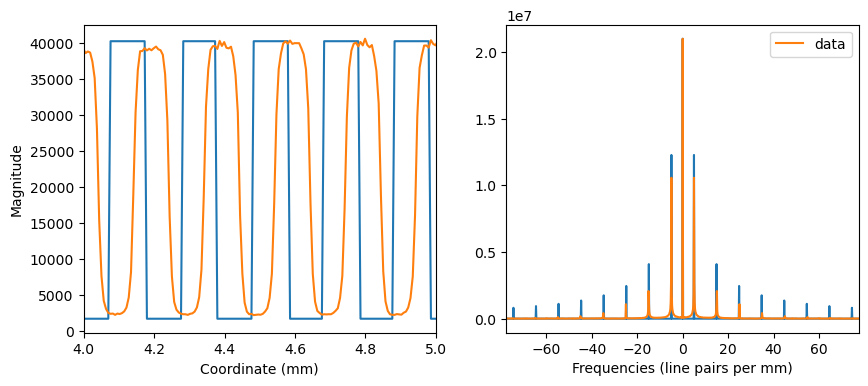

In [182]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# Apply cropping
line = im[200:1200,500]
t = np.arange(0, len(line))
offset = np.average(line)
scale = (np.max(line) - np.min(line))/2
wave = scale* sp.signal.square(2*np.pi* base_frequency*length_per_pixel * (t-7)) + offset
# large_wave = 1.005*scale* sp.signal.square(2*np.pi* 0.04 * (t-7)) + offset


# Plot length domain
ax[0].plot(t*length_per_pixel, wave)
ax[0].plot(t*length_per_pixel, line)
# ax[0].plot(t*length_per_pixel,large_wave)
ax[0].set_ylabel('Magnitude')
ax[0].set_xlabel('Coordinate (mm)')
ax[0].set_xlim(4,5)

# plt.xlim(400,600)

# Generate fully sampled square wave to reduce parasitic frequency effects
sampling_factor = 16
new_t = np.arange(0, len(line),1/sampling_factor)
wave_fft = fftshift(fft(scale* sp.signal.square(2*np.pi* base_frequency*length_per_pixel * (new_t-7))+ offset))/sampling_factor
new_sample_freq = fftshift(fftfreq(len(wave_fft), d = length_per_pixel/16))

ax[1].plot(new_sample_freq, np.abs(wave_fft))
ax[1].plot(fftshift(fftfreq(len(wave), d = length_per_pixel)), np.abs(fftshift(fft(line))), label='data')
# ax[1].plot(fftshift(fftfreq(len(wave), d = length_per_pixel)), np.abs(fftshift(fft(wave))), label='synthesised')
# ax[1].plot(fftshift(fftfreq(len(wave), d = length_per_pixel)) +1, np.abs(fftshift(fft(large_wave))), label='synthesised')
ax[1].set_xlim(x_freqs[0], x_freqs[-1])
ax[1].legend()
ax[1].set_xlabel('Frequencies (line pairs per mm)')


When the ideal grating function is manually fitted, we can extract its peaks.

Text(0.5, 1.0, 'FT of ideal grating function')

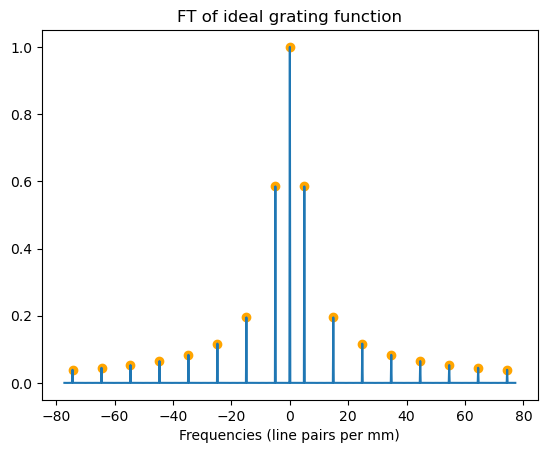

In [217]:
offset_height = np.max(np.abs(wave_fft))

# Normalised datasets are divided by offset_height
# also filter the lengthened fft to sample line lengths

crit = np.abs(new_sample_freq)< np.max(fftshift(fftfreq(len(wave), d = length_per_pixel)))
norm_wave_fft = wave_fft[crit]/ offset_height
norm_data  = np.abs(fftshift(fft(line)))/offset_height
simulated_fft_peaks, _ = sp.signal.find_peaks(np.abs(norm_wave_fft), threshold=0.001)

plot_slice_with_peaks(new_sample_freq[crit], np.abs(norm_wave_fft), simulated_fft_peaks)
plt.title('FT of ideal grating function')

Extract harmonic heights and place in DataFrame.

In [193]:
df = pd.DataFrame.from_dict({'harmonics': harmonics, 'simulated_fft_height':np.abs(norm_wave_fft)[simulated_fft_peaks][-len(harmonics):]})
df

,harmonics,simulated_fft_height
0,0,1.000000
1,1,0.584824
2,3,0.194948
3,5,0.116977
4,7,0.083563
5,9,0.065002
6,11,0.053193
7,13,0.045018
8,15,0.039025


Try on alternative. Peaks quite sensitive to threshold.

Text(0.5, 1.0, 'FFT of Image slice')

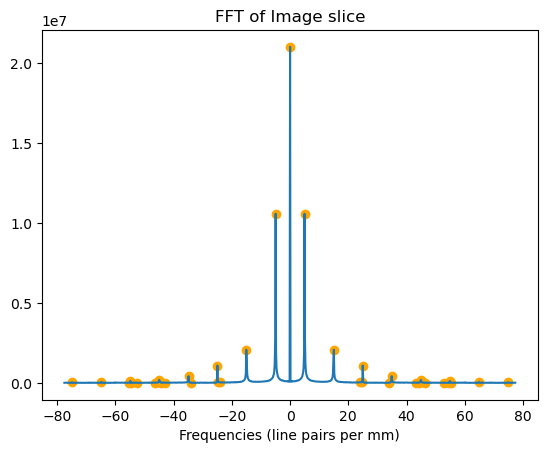

In [304]:
fft_arr = np.abs(fftshift(fft(line)))
fft_arr_freqs = fftshift(fftfreq(len(line), d=length_per_pixel))

peaks, _ = sp.signal.find_peaks(fft_arr, height=0.001*np.max(fft_arr))
peaks = peaks[find_matches(fft_arr_freqs[peaks]/base_frequency, harmonics, 0.04)]
# plt.scatter(fft_arr_freqs[peaks], fft_arr[peaks]/offset_height)
len(peaks) == len(harmonics)*2-1
plot_slice_with_peaks(fft_arr_freqs, fft_arr, peaks)
plt.title('FFT of Image slice')

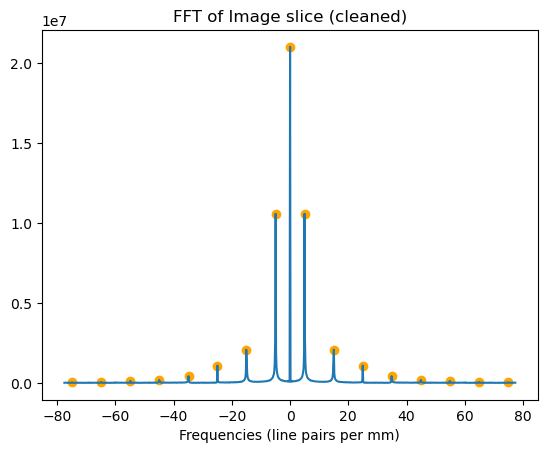

In [311]:
def filter_matches(input, match, rtol, height):
    """ Inputs and height are paired values. 
        For each value of match and for each value of input that is close enough to match,
            use choose the value of input that has the tallest height.
        Returns: 
            np.array of indices that have fulfilled the selection criteria
    """
    valid_indexes = []
    # Iterate over target values
    for num in match:
        tallest_value = 0
        tallest_idx = 0
        # Iterate over input array
        for idx, input_value in enumerate(input):
            if np.isclose(input_value, num, rtol=rtol):
                # Check heights only if the input value is close enough to the harmonic
                if height[idx] > tallest_value:
                    tallest_value = height[idx]
                    tallest_idx = idx
        valid_indexes.append(tallest_idx)
    return np.array(valid_indexes)

pos_neg_harmonics = np.append(-np.arange(1, x_freqs[-1]/base_frequency, 2, dtype=int)[::-1], harmonics) 
peaks = peaks[filter_matches(fft_arr_freqs[peaks]/base_frequency, pos_neg_harmonics, 0.04, fft_arr[peaks])]
plot_slice_with_peaks(fft_arr_freqs, fft_arr, peaks)
plt.title('FFT of Image slice (cleaned)')

positive_peak_values = (fft_arr[peaks]/offset_height)[-len(harmonics):]

In [312]:
positive_peak_values

array([0.99977034, 0.50339654, 0.09884387, 0.05171952, 0.02008774,
       0.00896258, 0.00589641, 0.00250735, 0.00174675])

### Calculating the MTF

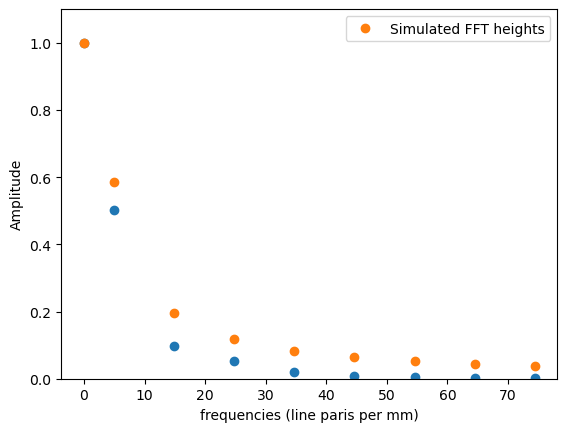

In [318]:
plt.errorbar(harmonics*base_frequency, positive_peak_values  , marker = 'o', ls='')
plt.errorbar(harmonics*base_frequency, df['simulated_fft_height'] , marker = 'o', ls='', label='Simulated FFT heights')

plt.xlabel('frequencies (line paris per mm)')
plt.ylabel('Amplitude')
# plt.xlim(-2,40)
plt.ylim(0,1.1)
plt.legend()

(0.0, 1.1)

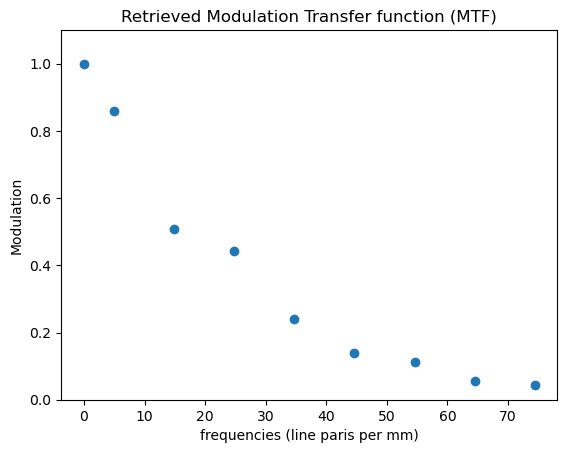

In [325]:
# plt.plot(harmonics*base_frequency, new_peaks / df['simulated_fft_height'])
# plt.scatter()
plt.errorbar(harmonics*base_frequency, positive_peak_values / df['simulated_fft_height'], marker = 'o', ls='', yerr=0.01*positive_peak_values/df['simulated_fft_height'])
plt.xlabel('frequencies (line paris per mm)')
plt.ylabel('Modulation')
plt.title('Retrieved Modulation Transfer function (MTF)')
plt.ylim(0,1.1)

This is the maximum harmonic the system (grating and optics) can capture.

In [529]:
2*e/m

0.0258

In [ ]:
x_freqs[-1]/base_frequency

7.808988764044943

# Analysis
* Applied to a stack of images

In [ ]:
AIR_IMAGE_PATH =  '../../data_store/20221023/f6_stack_air.tif'
im = io.imread(AIR_IMAGE_PATH)[:, 300:800, 300:600]
plt.figure(figsize=(6,6))
io.imshow(im[11])
print(im.shape)

NameError: name 'io' is not defined

In [ ]:
x_size = im.shape[2]
y_size = im.shape[1]

In [ ]:
ft_stack = fftshift(fft2(im), axes=[-1,-2])
ft_abs = np.abs(ft_stack)
ft_log = np.log10(ft_abs)

An example of the 2D FFT

Text(0.5, 0, 'x Frequency (cycle per pixel)')

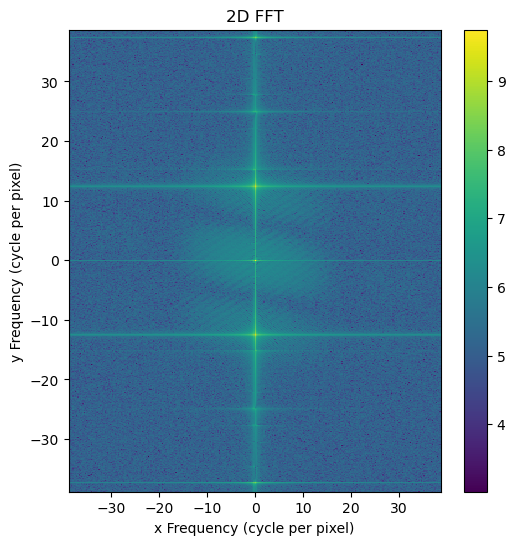

In [ ]:
plt.figure(figsize=(6,6))
plt.title('2D FFT')

x_freqs = fftshift(fftfreq(x_size, d = length_per_pixel)) 
y_freqs = fftshift(fftfreq(y_size, d = length_per_pixel) )
X,Y = np.meshgrid(x_freqs, y_freqs)

plt.pcolormesh(X,Y,ft_log[7], shading='auto')
plt.colorbar()
plt.ylabel('y Frequency (cycle per pixel)')
plt.xlabel('x Frequency (cycle per pixel)')


Plot out several frequencies for inspection

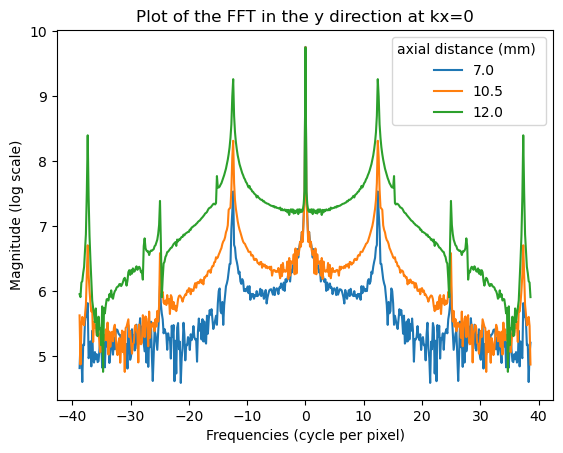

In [ ]:
plt.title('Plot of the FFT in the y direction at kx=0')
air_range = np.array([7, 8, 9, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 17])

def plot_line(idx):
    data = ft_log[idx,:, x_size//2]
    plt.plot(y_freqs, data, label=air_range[idx])

plot_line(0)
plot_line(4)
plot_line(7)

plt.xlabel('Frequencies (cycle per pixel)')
plt.ylabel('Magnitude (log scale)')
plt.legend(title='axial distance (mm) ')

Plot all the frequencies

Text(0, 0.5, 'Magnitude')

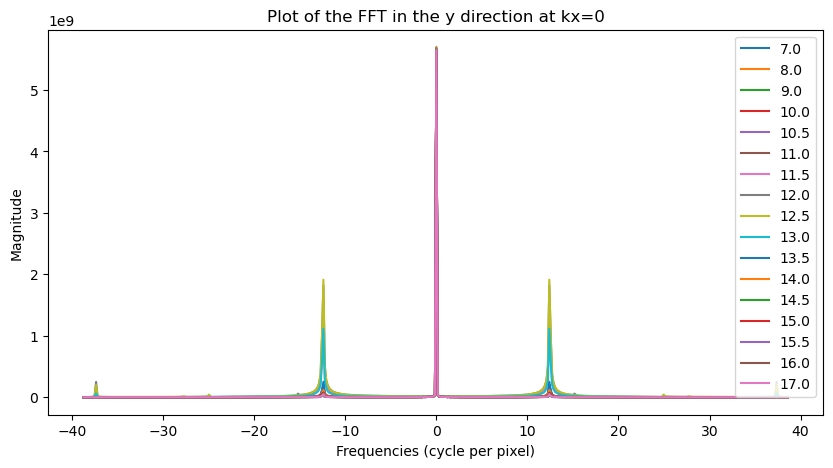

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Plot of the FFT in the y direction at kx=0')

plt.plot( y_freqs, (np.moveaxis(np.abs(ft_stack[:,:, x_size//2]), 0, -1)), label=air_range)
plt.legend()
plt.xlabel('Frequencies (cycle per pixel)')
plt.ylabel('Magnitude')

## Modelling

* Eyeball grating function
* Scaled everything to the correct range

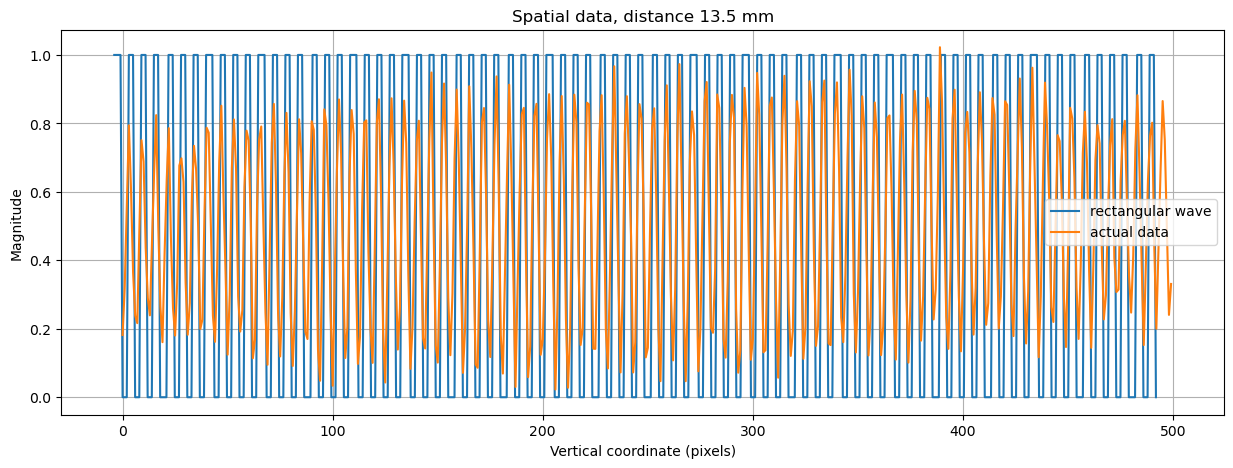

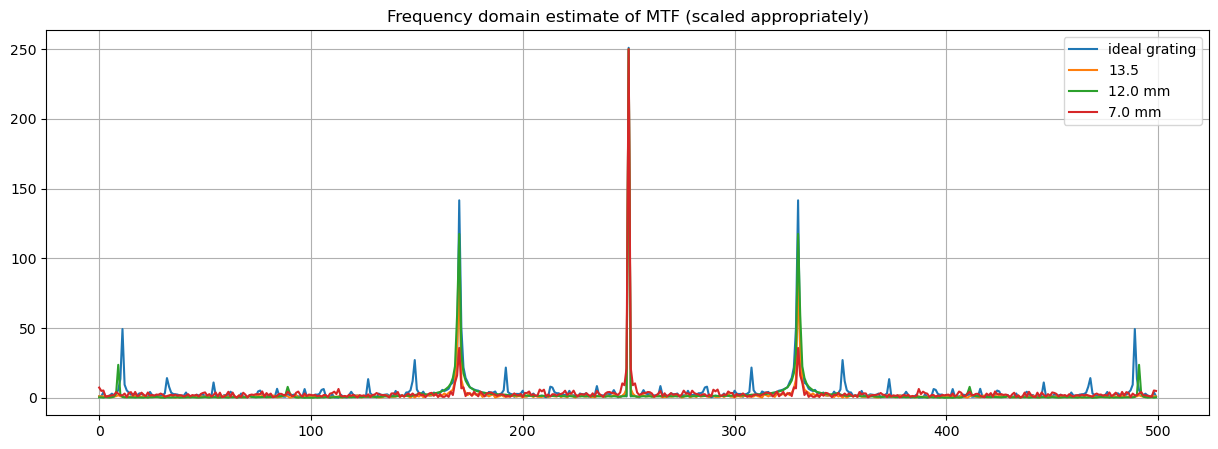

In [ ]:
import scipy as sp

plt.figure(figsize=(15,5))

t = np.linspace(0, y_size, y_size)


period = 6.23 # in pixels
shift = 4 # pixels

wave = 0.5*sp.signal.square(t) + 0.5
slice = 10

# Scaling the data
def scale_data(data):
    data_mid = (np.max(data) + np.min(data))/2
    data_mid = np.average(data)
    data_range = (np.max(data) - np.min(data))
    data = (data-data_mid)/data_range + 0.5
    return data

data = scale_data(im[slice,:, 0].astype('float64'))
plt.plot(period* (t-shift) / (2*np.pi), wave, label='rectangular wave' )
plt.plot(data, label='actual data')

# plt.xlim(300,400)

plt.title(f'Spatial data, distance {air_range[slice]} mm')
plt.ylabel('Magnitude')
plt.xlabel('Vertical coordinate (pixels)')

plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,5))
plt.title(f'Frequency domain estimate of MTF (scaled appropriately)')
plt.plot(np.abs(fftshift(fft(wave))), label='ideal grating')
plt.plot(np.abs(fftshift(fft(data))), label=f'{air_range[slice]}')
plt.plot(np.abs(fftshift(fft(scale_data(im[7,:, 0].astype('float64'))))), label=f'{air_range[7]} mm')
plt.plot(np.abs(fftshift(fft(scale_data(im[0,:, 0].astype('float64'))))), label=f'{air_range[0]} mm')
plt.grid()
plt.legend()
plt.show()

In [ ]:
WATER_IMAGE_PATH =  '../data_store/20221023/f6_stack_water.tif'
im_water = io.imread(WATER_IMAGE_PATH)[:, 300:800, 300:600]
plt.figure(figsize=(6,6))
io.imshow(im_water[11])
water_range = np.array([9, 10, 11, 12, 13, 14, 15, 16, 16.5, 17, 17.5, 18, 18.5, 19, 20, 21])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kenton/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/Physics/Year 4/project/optea/data_store/20221023/f6_stack_water.tif'

## DOF by contrast

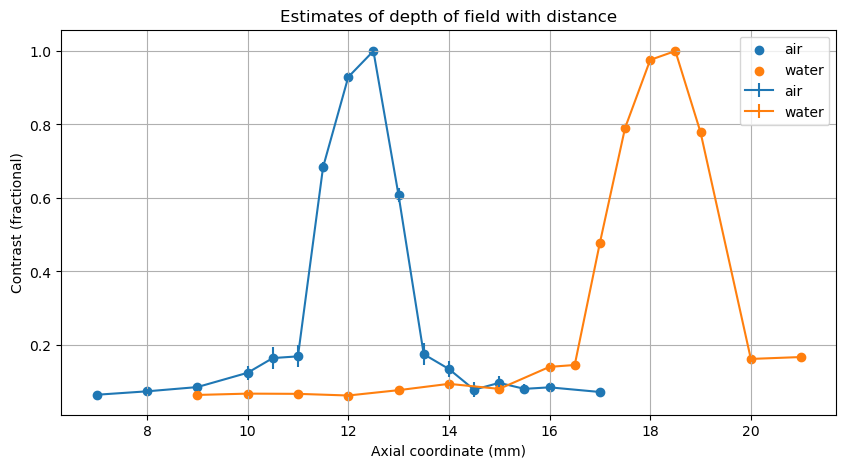

In [ ]:
def get_contrast(image_stack):
    """Obtains an estimate of the Michelson contrast

    Args:
        image_stack (np.array): focal scanning stack of 2D images, assuming to be the grating

    Returns:
        contrast_avg, contrast_std: mean and std deviation of contrast estimates
    """
    N_images = len(image_stack)
    N_sections = 20
    N_lines = 30

    results = np.zeros((N_images, N_lines, N_sections))
    maxes = np.zeros((N_images, N_lines))

    image_stack = image_stack.astype('float64')
    maxes = np.max(image_stack[:,:,0::5], axis=1)
    mins = np.min(image_stack[:,:,0::5], axis=1)

    # Michelson contrast
    contrast = (maxes - mins)/ (maxes + mins)
    contrast_avg = np.average(contrast, axis=1)
    contrast_std = np.std(contrast, axis=1)

    return contrast_avg, contrast_std

# Calculates the contrast of a stack of images of a grating in air and in water
air_contrast, air_contrast_std = get_contrast(im)
water_contrast, water_contrast_std = get_contrast(im_water)

# Plots the curve
plt.figure(figsize=(10,5))
plt.scatter(air_range, air_contrast/np.max(air_contrast), label='air')
plt.errorbar(air_range, air_contrast/np.max(air_contrast), yerr=air_contrast_std, label='air')
plt.scatter(water_range, water_contrast/np.max(water_contrast), label='water')
plt.errorbar(water_range, water_contrast/np.max(water_contrast), yerr=water_contrast_std, label='water')

plt.title('Estimates of depth of field with distance')
plt.xlabel('Axial coordinate (mm)')
plt.ylabel('Contrast (fractional)')
plt.grid(which='both')

plt.legend()


In [ ]:
air_contrast_std

array([0.00611823, 0.00686778, 0.01194487, 0.01948975, 0.02992609,
       0.0298086 , 0.01395772, 0.00906655, 0.01033586, 0.01881947,
       0.03014022, 0.02150894, 0.01998312, 0.01735562, 0.01216348,
       0.00812938, 0.00666477])

In [ ]:
im_water.shape

(16, 500, 300)

Quick analysis script

In [ ]:
PATH =  '../OPT Shared files/2022-10-31/2022-10-31-f6 depth sweep wide range stack/MMStack_Pos0.ome.tif'

im = io.imread(PATH)[:, 300:800, 300:600]
# plt.figure(figsize=(6,6))
# io.imshow(im_water[11])
dist_range = np.arange(25, 2, -1)

# Calculates the contrast of a stack of images of a grating in air and in water
air_contrast, air_contrast_std = get_contrast(im)

PATH =  '../OPT Shared files/2022-10-31/2022-10-31-f22 depth sweep wide range stack/MMStack_Pos0.ome.tif'
im = io.imread(PATH)[:, 300:800, 300:600]
dist_range_2 = np.arange(25, -1, -1)

# Calculates the contrast of a stack of images of a grating in air and in water
f22_contrast, f22_contrast_std = get_contrast(im)

# Plots the curve
plt.figure(figsize=(10,5))
plt.scatter(dist_range, air_contrast/np.max(air_contrast), label='f6')
plt.errorbar(dist_range, air_contrast/np.max(air_contrast), yerr=air_contrast_std)
plt.scatter(dist_range_2, f22_contrast/np.max(f22_contrast), label='f22')
plt.errorbar(dist_range_2, f22_contrast/np.max(f22_contrast), yerr=f22_contrast_std)

plt.title('Estimates of depth of field with distance')
plt.xlabel('Axial coordinate (mm)')
plt.ylabel('Contrast (fractional)')
plt.grid(which='both')

plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kenton/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/Physics/Year 4/project/OPT Shared files/2022-10-31/2022-10-31-f6 depth sweep wide range stack/MMStack_Pos0.ome.tif'